# IMDb

In [1]:
import pandas as pd
from scipy import stats
import pingouin as pg
import numpy as np
import statistics as stat
from operator import itemgetter
%matplotlib widget
import matplotlib.pyplot as plt

In [2]:
data_basics = pd.read_csv ("title_basics.tsv", sep = '\t')
data_ratings = pd.read_csv ("title_ratings.tsv", sep = '\t')

In [4]:
#not all elements in basics have corresponding ratings
# filter rows based on list values
mask = data_basics['tconst'].isin(data_ratings.tconst)
data_basics = data_basics[mask]


In [5]:
#select only the movies with ratings
mask = data_basics['titleType'] == 'movie'
movies = data_basics[mask]

#select only the ratings of movies with ratings
mask = data_ratings['tconst'].isin(movies.tconst)
movie_ratings = data_ratings[mask]

In [6]:
#remove the ones without start date
mask = movies['startYear'] != "\\N"
movies = movies[mask]

#remove them from ratings too
mask = data_ratings['tconst'].isin(movies.tconst)
movie_ratings = movie_ratings[mask]

/var/folders/59/wqcf121152z7r7_l36f3xcvr0000gn/T/ipykernel_39112/3175007679.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movie_ratings = movie_ratings[mask]


In [7]:
first_year = 2000
last_year = 2020

print("The data spans between " + str(np.min(movies['startYear'])) + " and " + str(np.max(pd.to_numeric(movies['startYear']))) + ".")
print("We are interested in the data between " + str(first_year) + " and " + str(last_year) + ".")

The data spans between 1894 and 2025.
We are interested in the data between 2000 and 2020.


In [8]:
#remove the ones without start date
mask_min = movies['startYear'].apply(pd.to_numeric) >= first_year 
movies = movies[mask_min]
mask_max = movies['startYear'].apply(pd.to_numeric) <= last_year
movies = movies[mask_max]


#remove them from ratings too
mask = movie_ratings['tconst'].isin(movies.tconst)
movie_ratings = movie_ratings[mask]

print("Selected data between " + str(np.min(movies['startYear'])) + " and " + str(np.max(pd.to_numeric(movies['startYear']))) + ".")

Selected data between 2000 and 2020.


In [9]:
min_votes = 1000
mask = movie_ratings['numVotes'].apply(pd.to_numeric) >= min_votes 
movie_ratings = movie_ratings[mask]

mask = movies['tconst'].isin(movie_ratings.tconst)
movies = movies[mask]

In [10]:
#remove adult movies
mask = movies['isAdult'].apply(pd.to_numeric) == 0 
movies = movies[mask]

mask = movie_ratings['tconst'].isin(movies.tconst)
movie_ratings = movie_ratings[mask]

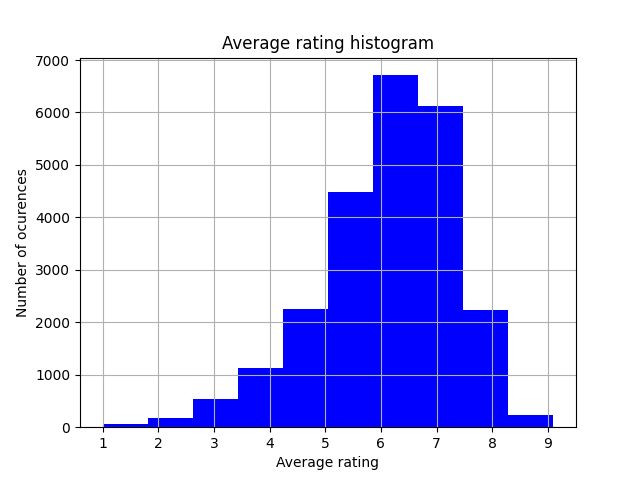

In [11]:
#plot average rating results for all movies
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.hist(movie_ratings['averageRating'], color='b')
    
ax.set_xlabel('Average rating')
ax.set_ylabel('Number of ocurences')
ax.set_title('Average rating histogram')
ax.grid()

In [12]:
#Select genres of interest
genres = ['Comedy', 'Drama', 'Fantasy', 'Horror', 'Romance', 'Action', 'Thriller', 'Sci-Fi', 'Documentary']
multi_genre = 1 # 0 drop multi-genre, 1 keep multi genre without repetition (recommended)

match multi_genre:
    case 0:
        movies_split = {gen: movies[movies['genres'] == gen] for gen in genres}
        movie_ratings_split = {gen: movie_ratings[movie_ratings['tconst'].isin(movies_split[gen]['tconst'])] for gen in genres}
        print([str(gen)+ ': ' + str(len(movies_split[gen])) for gen in genres])
    
    case 1:
        movies_split = {gen: movies[movies['genres'].apply(lambda x: x.split(',')[0]) == gen] for gen in genres}
        movie_ratings_split = {gen: movie_ratings[movie_ratings['tconst'].isin(movies_split[gen]['tconst'])] for gen in genres}
        print([str(gen)+ ': ' + str(len(movies_split[gen])) for gen in genres])

['Comedy: 6229', 'Drama: 5769', 'Fantasy: 127', 'Horror: 1439', 'Romance: 81', 'Action: 4449', 'Thriller: 171', 'Sci-Fi: 42', 'Documentary: 1080']


Text(0.04, 0.5, 'Number of ocurences')

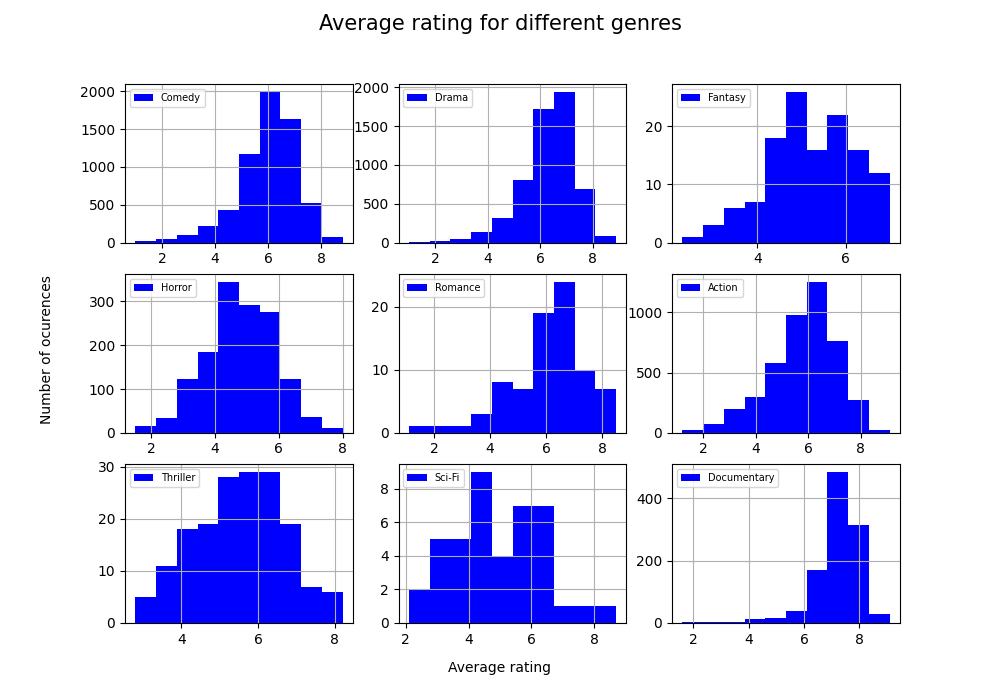

In [13]:
#plot relative error results for each genre
fig, ax = plt.subplots(int(np.ceil(len(genres)/3)), 3, figsize=(10,7))
ax = ax.ravel()
fig.suptitle('Average rating for different genres', fontsize=15)
for axes, i in zip(ax, range(0, len(genres))):
    axes.hist(movie_ratings_split[genres[i]]['averageRating'], color='b')
    axes.legend([genres[i]], loc="upper left", fontsize=7)
    axes.grid()
fig.text(0.5, 0.04, 'Average rating', ha='center')
fig.text(0.04, 0.5, 'Number of ocurences', va='center', rotation='vertical')


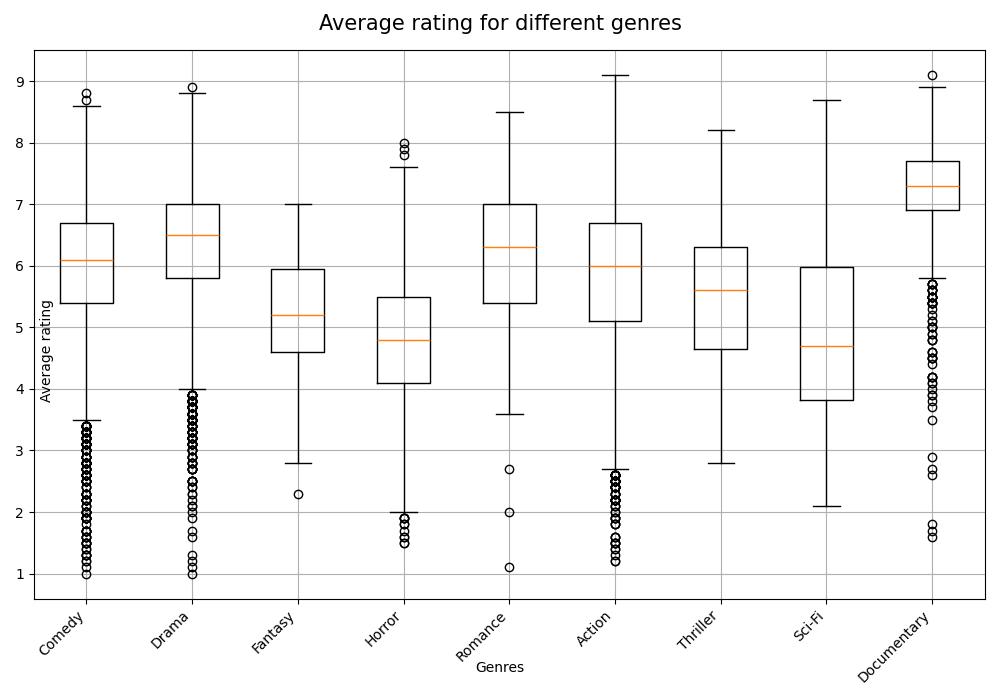

In [14]:
#Organize data to plot in a single graph
ratings_genre = [movie_ratings_split[genre]['averageRating'] for genre in genres]

#plot average ratings results in a box
fig, ax = plt.subplots(figsize=(10,7))

fig.suptitle('Average rating for different genres', fontsize=15)
ax.boxplot(ratings_genre)
ax.grid()

ax.set_xticklabels(genres, rotation=45, ha='right', fontsize=10)
fig.text(0.5, 0.04, 'Genres', ha='center')
fig.text(0.04, 0.5, 'Average rating', va='center', rotation='vertical')
plt.tight_layout()

In [15]:
outliers_info = {}
outliers = {} 
movie_ratings_split_filter = {}
# calculate percentage of outliers
for genre in genres:
    data = movie_ratings_split[genre]['averageRating']
    q1 = np.percentile(data, 25) #first quartile
    q3 = np.percentile(data, 75) # third quartlie
    iqr = q3 - q1 #interquartile range
    
    #Tukey, J. W. (1977). Exploratory Data Analysis. 
    #Outlier limit defined by matplotlib
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers[genre] = data[(data < lower_bound) | (data > upper_bound)] 
    
    #percentage of the samples that are considered "outliers"
    count = len(outliers[genre])
    percentage = count / len(data) * 100
    outliers_info[genre] = f"{count} outliers ({percentage:.2f}%)"
    
    #filter outliers
    mask = (data >= lower_bound) & (data <= upper_bound)
    movie_ratings_split_filter[genre] = pd.DataFrame(data[mask])

# Print outlier info per genre
for genre, info in outliers_info.items():
    print(f"{genre}: {info}")

Comedy: 193 outliers (3.10%)
Drama: 163 outliers (2.83%)
Fantasy: 1 outliers (0.79%)
Horror: 14 outliers (0.97%)
Romance: 3 outliers (3.70%)
Action: 79 outliers (1.78%)
Thriller: 0 outliers (0.00%)
Sci-Fi: 0 outliers (0.00%)
Documentary: 64 outliers (5.93%)


In [16]:
#evaluate outliers

#check for wrong type
[print(outlier) for genre in genres for outlier in outliers[genre] if not isinstance(outlier, float)]
#check non-positive values
[print(outlier) for genre in genres for outlier in outliers[genre] if outlier <= 0.0]
#check values bigger than 10
[print(outlier) for genre in genres for outlier in outliers[genre] if outlier > 10.0]

[]

Text(0.04, 0.5, 'Number of ocurences')

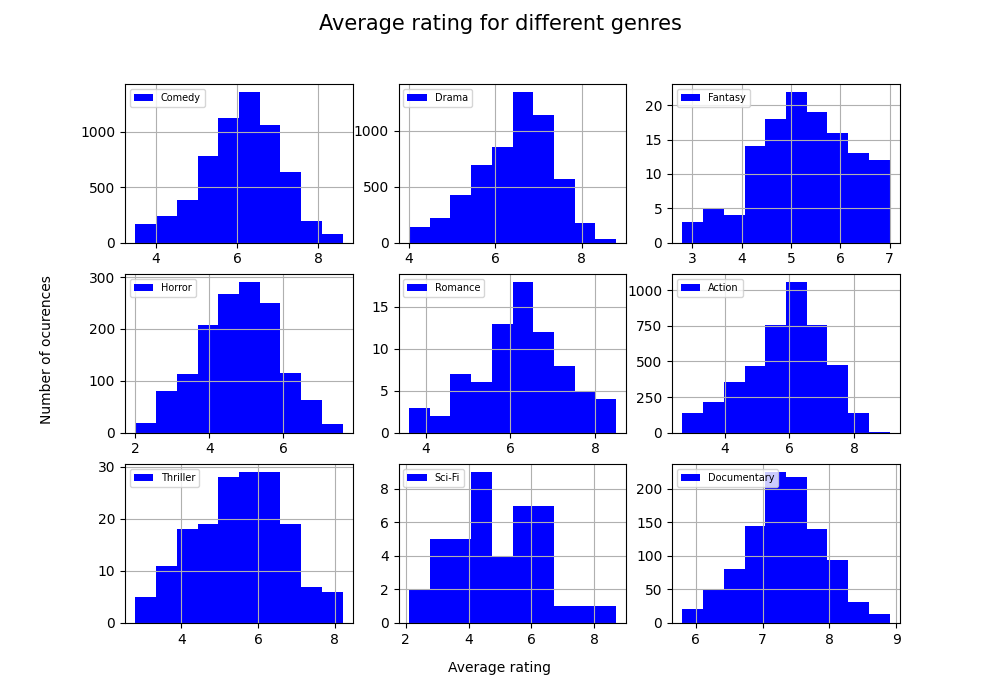

In [17]:
#plot relative error results without outliers
fig, ax = plt.subplots(int(np.ceil(len(genres)/3)), 3, figsize=(10,7))
ax = ax.ravel()
fig.suptitle('Average rating for different genres', fontsize=15)
for axes, i in zip(ax, range(0, len(genres))):
    axes.hist(movie_ratings_split_filter[genres[i]]['averageRating'], color='b')
    axes.legend([genres[i]], loc="upper left", fontsize=7)
    axes.grid()
fig.text(0.5, 0.04, 'Average rating', ha='center')
fig.text(0.04, 0.5, 'Number of ocurences', va='center', rotation='vertical')

In [18]:
parameters = {} #genres, []

#Quick sample parameters check
for genre in genres:
    parameters[genre] = {
        "mean" : (stat.mean(movie_ratings_split[genre]['averageRating'])),  
        "mode" : ((stat.mode(movie_ratings_split[genre]['averageRating']))), 
        "median" : (stat.median(movie_ratings_split[genre]['averageRating'])), 
        "std" : (stat.stdev(movie_ratings_split[genre]['averageRating'])),
        "var" : (stat.stdev(movie_ratings_split[genre]['averageRating']))**2}
    
vars = list(map(itemgetter('var'), parameters.values()))

print(parameters)

print(max(vars)/min(vars))

{'Comedy': {'mean': 5.988794349012682, 'mode': 6.2, 'median': 6.1, 'std': 1.102803242314333, 'var': 1.2161749912590054}, 'Drama': {'mean': 6.354480845900503, 'mode': 6.7, 'median': 6.5, 'std': 1.0136060054142175, 'var': 1.0273971342117667}, 'Fantasy': {'mean': 5.21496062992126, 'mode': 4.9, 'median': 5.2, 'std': 0.9951532338063097, 'var': 0.9903299587551557}, 'Horror': {'mean': 4.775260597637248, 'mode': 4.3, 'median': 4.8, 'std': 1.088701385791403, 'var': 1.1852707074241213}, 'Romance': {'mean': 6.08641975308642, 'mode': 6.4, 'median': 6.3, 'std': 1.3598486208416503, 'var': 1.8491882716049384}, 'Action': {'mean': 5.8297370195549565, 'mode': 6.1, 'median': 6.0, 'std': 1.2857387191911023, 'var': 1.653124054027176}, 'Thriller': {'mean': 5.512865497076024, 'mode': 6.1, 'median': 5.6, 'std': 1.143502606562097, 'var': 1.30759821121431}, 'Sci-Fi': {'mean': 4.904761904761905, 'mode': 4.5, 'median': 4.699999999999999, 'std': 1.4083292957766038, 'var': 1.983391405342625}, 'Documentary': {'mean'

In [19]:
parameters = {} #genres, []

#Quick sample parameters check
for genre in genres:
    parameters[genre] = {
        "mean" : (stat.mean(movie_ratings_split_filter[genre]['averageRating'])),  
        "mode" : ((stat.mode(movie_ratings_split_filter[genre]['averageRating']))), 
        "median" : (stat.median(movie_ratings_split_filter[genre]['averageRating'])), 
        "std" : (stat.stdev(movie_ratings_split_filter[genre]['averageRating'])),
        "var" : (stat.stdev(movie_ratings_split_filter[genre]['averageRating']))**2}
    
vars = list(map(itemgetter('var'), parameters.values()))

print(parameters)

print(max(vars)/min(vars))

{'Comedy': {'mean': 6.093223989396952, 'mode': 6.2, 'median': 6.2, 'std': 0.9368770826338937, 'var': 0.8777386679645957}, 'Drama': {'mean': 6.44306100606493, 'mode': 6.7, 'median': 6.5, 'std': 0.8736978406209924, 'var': 0.7633479167057851}, 'Fantasy': {'mean': 5.238095238095238, 'mode': 4.9, 'median': 5.2, 'std': 0.9642287813880807, 'var': 0.929737142857143}, 'Horror': {'mean': 4.792140350877193, 'mode': 4.3, 'median': 4.8, 'std': 1.0509666403669542, 'var': 1.1045308791642028}, 'Romance': {'mean': 6.246153846153846, 'mode': 6.4, 'median': 6.4, 'std': 1.0984868350022803, 'var': 1.206673326673327}, 'Action': {'mean': 5.8953318077803205, 'mode': 6.1, 'median': 6.1, 'std': 1.1991208316087494, 'var': 1.4378907687980587}, 'Thriller': {'mean': 5.512865497076024, 'mode': 6.1, 'median': 5.6, 'std': 1.143502606562097, 'var': 1.30759821121431}, 'Sci-Fi': {'mean': 4.904761904761905, 'mode': 4.5, 'median': 4.699999999999999, 'std': 1.4083292957766038, 'var': 1.983391405342625}, 'Documentary': {'mea

In [20]:
for genre in genres:
    stat, p = stats.shapiro(movie_ratings_split[genre]['averageRating'])
    print(genre, "p =", p)

Comedy p = 5.0370181455637146e-40
Drama p = 1.043286368917628e-38
Fantasy p = 0.06879198712682649
Horror p = 0.013038558259775186
Romance p = 0.0010491154783380005
Action p = 3.0337740239281487e-28
Thriller p = 0.3310637370707889
Sci-Fi p = 0.8538267281233596
Documentary p = 1.5010587897944325e-30


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6229.
  res = hypotest_fun_out(*samples, **kwds)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5769.
  res = hypotest_fun_out(*samples, **kwds)


In [21]:
for genre in genres:
    stat, p = stats.shapiro(movie_ratings_split_filter[genre]['averageRating'])
    print(genre, "p =", p)

Comedy p = 1.2082315484385179e-20
Drama p = 6.397350936913256e-23
Fantasy p = 0.07844296286662188
Horror p = 0.00038963319953432907
Romance p = 0.6023431147512242
Action p = 5.1054087106080476e-24
Thriller p = 0.3310637370707889
Sci-Fi p = 0.8538267281233596
Documentary p = 0.00032143304404345517


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6036.
  res = hypotest_fun_out(*samples, **kwds)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5606.
  res = hypotest_fun_out(*samples, **kwds)


In [22]:
for genre in genres:
    values = movie_ratings_split[genre]['averageRating']
    print(genre, "skew =", stats.skew(values), "kurtosis =", stats.kurtosis(values))

Comedy skew = -0.934657456214611 kurtosis = 1.6461302161308282
Drama skew = -0.9359630059249698 kurtosis = 1.619205001309897
Fantasy skew = -0.3264844233494173 kurtosis = -0.24910404014268028
Horror skew = -0.11743617861541672 kurtosis = -0.15546628853866418
Romance skew = -1.0262208387748746 kurtosis = 1.923463927066849
Action skew = -0.6270367477824607 kurtosis = 0.19159677556105237
Thriller skew = -0.09946088938557858 kurtosis = -0.4584928217963622
Sci-Fi skew = 0.31416296898931506 kurtosis = -0.13388185137578557
Documentary skew = -2.0527742939321474 kurtosis = 7.793082716486998


In [23]:
for genre in genres:
    values = movie_ratings_split_filter[genre]['averageRating']
    print(genre, "skew =", stats.skew(values), "kurtosis =", stats.kurtosis(values))

Comedy skew = -0.33066104082361447 kurtosis = -0.04616380926551367
Drama skew = -0.3846921492948908 kurtosis = -0.0577667089697278
Fantasy skew = -0.212167396186395 kurtosis = -0.5102646868860292
Horror skew = -0.04724852811544185 kurtosis = -0.405058446459146
Romance skew = -0.1868749315485716 kurtosis = -0.29427650898528457
Action skew = -0.43214594122301914 kurtosis = -0.2584779558886865
Thriller skew = -0.09946088938557858 kurtosis = -0.4584928217963622
Sci-Fi skew = 0.31416296898931506 kurtosis = -0.13388185137578557
Documentary skew = -0.10408699584522874 kurtosis = -0.0700266178899085


Possible courses of action:
-Resample with the same sample size + regular anova: pros: balanced design + simple cons: heteroscedaticity, maybe small sample size could impact normality
-Regular anova (accept ratio as okay): pros: quick and easy, higher sample sizes (?) cons:  heteroscedaticity, unbalanced design
-Welch ANOVA or Brown-Forsythe (with post-hoc analysis): pros: more robust to unbalanced sample sizes and heteroscedasticity cons: higher story points

In [24]:
samples = np.array([movie_ratings_split[genre]['averageRating'].values for genre in genres], dtype=object)

#Since the sample ratio is higher than 2, regular ANOVA is not suitable
# Applied Linear Statistical Models by Kutner et all
#Welch’s ANOVA test with different sample sizes
f_welch, p_welch = stats.f_oneway(*samples, axis=0, equal_var=False)
print(f_welch)
print(p_welch)

571.3499641723174
9.829454001971297e-250


In [25]:
movie_ratings_split_flat= pd.DataFrame(
    [(genre, rating) 
     for genre in genres 
     for rating in movie_ratings_split[genre]['averageRating']],
    columns=['genre', 'averageRating']
)

In [26]:
#Post Hoc analysis
#Which groups differ?
#Games-Howell test

Games_Howell = pg.pairwise_gameshowell(data=movie_ratings_split_flat, dv='averageRating', between='genre' )

print(Games_Howell)

              A            B   mean(A)   mean(B)      diff        se  \
0        Action       Comedy  5.829737  5.988794 -0.159057  0.023808   
1        Action  Documentary  5.829737  7.173333 -1.343596  0.032495   
2        Action        Drama  5.829737  6.354481 -0.524744  0.023445   
3        Action      Fantasy  5.829737  5.214961  0.614776  0.090385   
4        Action       Horror  5.829737  4.775261  1.054476  0.034572   
5        Action      Romance  5.829737  6.086420 -0.256683  0.152319   
6        Action       Sci-Fi  5.829737  4.904762  0.924975  0.218163   
7        Action     Thriller  5.829737  5.512865  0.316872  0.089545   
8        Comedy  Documentary  5.988794  7.173333 -1.184539  0.029658   
9        Comedy        Drama  5.988794  6.354481 -0.365686  0.019322   
10       Comedy      Fantasy  5.988794  5.214961  0.773834  0.089404   
11       Comedy       Horror  5.988794  4.775261  1.213534  0.031921   
12       Comedy      Romance  5.988794  6.086420 -0.097625  0.15